# Visualizing Evaluation Results

This notebook demonstrates how to visualize and compare results from different model experiments. We'll look at:

1. Loading simulation results from finetuned and continental models
2. Comparing metrics across different model versions
3. Visualizing the differences using various plots

The notebook uses simulation outputs from two model versions (old and new) in both finetuned and continental configurations.


In [21]:
# Import required libraries
from pathlib import Path
import xarray as xr
from hydroml.evaluation import graphs as g
import matplotlib.pyplot as plt
from tqdm import tqdm
from hydroml.evaluation.metrics import get_metrics

# Function to read simulation results from finetuned models
# This reads multiple simulation.nc files from individual catchment directories
# and concatenates them into a single dataset
def read_simulation_of_finetuned_model(p, finetune_directory = 'finetune_all', leave=False):
    ds_list = []
    for path in tqdm(list((Path(p)/finetune_directory).glob('*/*/results/simulation.nc')), desc='Reading finetuned simulation', leave=leave):
        ds = xr.open_dataset(path)
        ds_list.append(ds)

    return xr.concat(ds_list, dim='catchment_id')


# Function to read simulation results from continental models
# This reads a single simulation.nc file containing results for all catchments
def read_simulation_of_continental_model(p):
    return xr.open_dataset(Path(p) / 'results' / 'simulation.nc')

# Comparing Model Performance

Now that we have loaded our simulation results, let's analyze and visualize the performance metrics across different model configurations.

We'll focus on:
- NSE (Nash-Sutcliffe Efficiency) scores for each catchment
- Distribution of performance metrics using exceedance curves
- Comparing performance between finetuned and continental models

 First, we'll set up the paths to our model experiments and load the simulation results.


In [22]:
# this is the path to the models you want to compare
experiment_path_mapping = { 
    'qc_1': 'P://work//sho108//hydroml//results//toos_qc_validation//241216120325_5de9',
    'qc_2': 'P://work//sho108//hydroml//results//toos_qc_validation//241216185454_b6fb',
    'c_1': 'P://work//sho108//hydroml//results//toos_c_validation//241216192856_a83f',
    
}


In [23]:
# read simulation results from finetuned models
finetuned_simulations = {f'{k}_finetuned':read_simulation_of_finetuned_model(v) for k, v in experiment_path_mapping.items()}
continental_simulation = {f'{k}_continental':read_simulation_of_continental_model(v) for k, v in experiment_path_mapping.items()}

all_simulations = {**finetuned_simulations, **continental_simulation}


In [24]:
# concatenate all simulation results into a single dataset
ds = xr.concat(all_simulations.values(), dim='experiments').assign_coords(experiments=list(all_simulations.keys())).squeeze()


## Performance Metrics Analysis

In this section, we calculate and analyze performance metrics across all catchments and model experiments.

The `get_metrics()` function computes several hydrological evaluation metrics including:
- Nash-Sutcliffe Efficiency (NSE)
- Kling-Gupta Efficiency (KGE) 
- Other relevant metrics

Input Dataset Structure:
- **Experiments**: Contains both finetuned and continental model results
- **Variables**:
  - Simulated streamflow (model predictions)
  - Observed streamflow (ground truth)
  - Additional metadata

The metrics will help us quantitatively compare model performance across different configurations and catchments.

In [25]:

metrics = get_metrics(ds)

# now we can inspect the metrics, here we look at NSE
metrics.to_dataframe()['nse'].unstack()


c:\Users\sho108\AppData\Local\pypoetry\Cache\virtualenvs\hydroml-dFLAodHf-py3.11\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\sho108\AppData\Local\pypoetry\Cache\virtualenvs\hydroml-dFLAodHf-py3.11\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\sho108\AppData\Local\pypoetry\Cache\virtualenvs\hydroml-dFLAodHf-py3.11\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\sho108\AppData\Local\pypoetry\Cache\virtualenvs\hydroml-dFLAodHf-py3.11\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\sho108\AppData\

experiments,qc_1_finetuned,qc_2_finetuned,c_1_finetuned,qc_1_continental,qc_2_continental,c_1_continental
catchment_id,,,,,,
102101A,0.287034,-0.366527,-0.005387,0.399578,0.367988,0.477361
104001A,0.626392,0.607481,0.578017,0.621222,0.462170,0.564719
105101A,0.590319,0.632638,0.688484,-0.924713,-0.895629,-1.044382
105102A,0.142363,-0.115327,-0.601462,0.036103,0.002300,-0.042535
105105A,0.404815,0.588827,0.671565,0.093816,0.484427,0.204214
...,...,...,...,...,...,...
G8200045,0.520861,0.518840,0.548729,0.523431,0.494013,0.609539
G8210010,0.525265,0.373608,0.402109,0.535093,0.568934,0.576974
G9030124,0.439573,0.400464,0.418172,0.281013,0.325879,0.028544


## Exceedance Probability Analysis

Next, we'll analyze the distribution of NSE scores across catchments using exceedance probability curves.

An exceedance probability curve shows:
- The probability that a given NSE value will be exceeded
- Distribution and spread of model performance across catchments
- Comparison between different model configurations

We'll focus on catchments where all models produced valid results (no NaN values) for fair comparison.


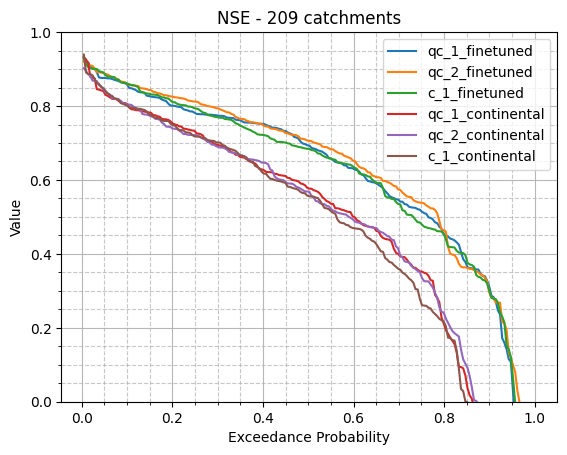

In [26]:
# to make sure we are comparing same catchments, we drop catchments with nan - this should not be the case normally, but in case some of the finetuneing is failed, we can still compare the catchments with non-nan NSE

non_nan_metrics = metrics.dropna(dim='catchment_id')

for experiment in ds.experiments.values:
    g.exceedance_curve(non_nan_metrics.sel(experiments=experiment)['nse'])


plt.title(f'NSE - {len(non_nan_metrics.catchment_id)} catchments')
plt.ylim(0, 1)
plt.legend(ds.experiments.values)
plt.grid(True, which='major', linestyle='-', alpha=0.9)
plt.grid(True, which='minor', linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.show()
